In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

RANDOM_STATE = 42


In [14]:
data = load_breast_cancer()
X = data.data
y = data.target
feature_names = data.feature_names

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

X.shape, y.shape, X_train.shape, X_test.shape


((569, 30), (569,), (455, 30), (114, 30))

In [15]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

knn_param_grid = {
    "knn__n_neighbors": [3, 5, 7, 9, 11],
    "knn__weights": ["uniform", "distance"],
    "knn__p": [1, 2]  # Manhattan vs Euclidean
}

knn_gs = GridSearchCV(
    knn_pipeline,
    param_grid=knn_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)
knn_gs.fit(X_train, y_train)

print("Mejores params KNN:", knn_gs.best_params_)
print("Mejor f1 (cv):", knn_gs.best_score_)


Mejores params KNN: {'knn__n_neighbors': 7, 'knn__p': 2, 'knn__weights': 'uniform'}
Mejor f1 (cv): 0.9774783998014488


In [16]:
y_pred_knn = knn_gs.predict(X_test)
print("== KNN ==")
print(classification_report(y_test, y_pred_knn, target_names=data.target_names))

cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_knn


== KNN ==
              precision    recall  f1-score   support

   malignant       1.00      0.93      0.96        42
      benign       0.96      1.00      0.98        72

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



array([[39,  3],
       [ 0, 72]])

ROC-AUC (KNN): 0.9884259259259259


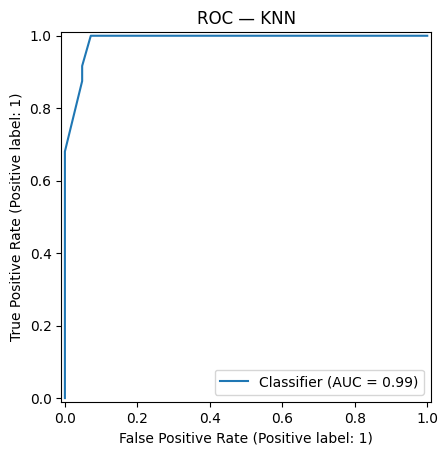

In [17]:
if hasattr(knn_gs.best_estimator_[-1], "predict_proba"):
    y_proba_knn = knn_gs.predict_proba(X_test)[:, 1]
else:
    y_proba_knn = knn_gs.decision_function(X_test)

auc_knn = roc_auc_score(y_test, y_proba_knn)
print("ROC-AUC (KNN):", auc_knn)

RocCurveDisplay.from_predictions(y_test, y_proba_knn)
plt.title("ROC — KNN")
plt.show()


In [18]:
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(probability=True, random_state=RANDOM_STATE))
])

svm_param_grid = {
    "svm__C": [0.1, 1, 3, 10],
    "svm__gamma": ["scale", 0.01, 0.1, 1],
    "svm__kernel": ["rbf"]
}

svm_gs = GridSearchCV(
    svm_pipeline,
    param_grid=svm_param_grid,
    scoring="f1",
    cv=5,
    n_jobs=-1
)
svm_gs.fit(X_train, y_train)

print("Mejores params SVM:", svm_gs.best_params_)
print("Mejor f1 (cv):", svm_gs.best_score_)


Mejores params SVM: {'svm__C': 10, 'svm__gamma': 0.01, 'svm__kernel': 'rbf'}
Mejor f1 (cv): 0.9844323436002114


In [19]:
y_pred_svm = svm_gs.predict(X_test)
print("== SVM ==")
print(classification_report(y_test, y_pred_svm, target_names=data.target_names))

cm_svm = confusion_matrix(y_test, y_pred_svm)
cm_svm


== SVM ==
              precision    recall  f1-score   support

   malignant       0.98      0.98      0.98        42
      benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114



array([[41,  1],
       [ 1, 71]])

ROC-AUC (SVM): 0.9976851851851851


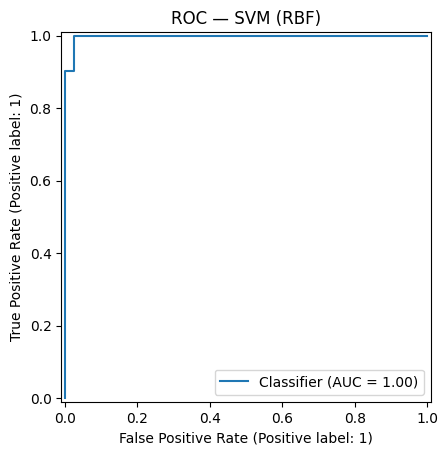

In [20]:
y_proba_svm = svm_gs.predict_proba(X_test)[:, 1]
auc_svm = roc_auc_score(y_test, y_proba_svm)
print("ROC-AUC (SVM):", auc_svm)

RocCurveDisplay.from_predictions(y_test, y_proba_svm)
plt.title("ROC — SVM (RBF)")
plt.show()


In [21]:
results = pd.DataFrame({
    "modelo": ["KNN", "SVM"],
    "f1_cv_best": [knn_gs.best_score_, svm_gs.best_score_],
    "test_precision": [
        classification_report(y_test, y_pred_knn, output_dict=True)["weighted avg"]["precision"],
        classification_report(y_test, y_pred_svm, output_dict=True)["weighted avg"]["precision"],
    ],
    "test_recall": [
        classification_report(y_test, y_pred_knn, output_dict=True)["weighted avg"]["recall"],
        classification_report(y_test, y_pred_svm, output_dict=True)["weighted avg"]["recall"],
    ],
    "test_f1": [
        classification_report(y_test, y_pred_knn, output_dict=True)["weighted avg"]["f1-score"],
        classification_report(y_test, y_pred_svm, output_dict=True)["weighted avg"]["f1-score"],
    ],
    "test_auc": [auc_knn, auc_svm]
})
results


,modelo,f1_cv_best,test_precision,test_recall,test_f1,test_auc
0,KNN,0.977478,0.974737,0.973684,0.973465,0.988426
1,SVM,0.984432,0.982456,0.982456,0.982456,0.997685
